# Data analysis

General jupyter file for data analysis.

- Merge the dhcp and the multifact data
- apply the QC
- Do normalization if needed
- Visualize key variables against gestational age, assess differences
- save final variables for the statistical analysis


In [35]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [44]:
# Data paths
dhcp_data = 'data/dhcp_quantitative_values.csv'
dhcp_metadata = 'data/dhcp_fetalresults_final.csv'

multifact_metadata = "data/multifact_acquisition_parameters.csv"
multifact_data = "data/multifact_DATA_MASTER.csv"
multifact_qc = "data/multifact_QC_NEW.csv"

## Load data
df_dhcp = pd.read_csv(dhcp_data)
df_dhcp_meta = pd.read_csv(dhcp_metadata)

df_multifact = pd.read_csv(multifact_data)
df_multifact_meta = pd.read_csv(multifact_metadata)
df_multifact_qc = pd.read_csv(multifact_qc)

## Apply quality control

Apply the quality control of the data by removing those with bad quality control indicated by df_multifact_qc. We also remove clear outliers.

(in the current code, qc HAS ALREADY BEEN PERFORMED)


In [37]:
# Remove all rows in df_multifact where column "dhcp" is 0 in df_multifact_qc. The two datasets share the same "sub" column

# Print the size before
print(df_multifact.shape)

df_multifact = df_multifact[df_multifact['sub'].isin(df_multifact_qc[df_multifact_qc['dhcp'] == 1]['sub'])]

# Print the size after
print(df_multifact.shape)



(172, 516)
(172, 516)


# Merge and clean the data

Merge the dhcp and the multifact data. For this, we need to adapt the columns to be the same in both dataframes.

We also:

- Add a new variable "center" indicating from which study the data comes from
- The DX for the multifact data is added, is = 5
- DX 5 and 6 are combined to 5, but the separation is made clear in the variable "center"

DX:
1 ACC
2 DISGENESIA CC
3 CC< 5
4 IUGR
5 CONTROLS VENTRICULOMEGALY
6 CONTROLS


In [49]:
# identifier is "sub" for multifact and "participant_id" for dhcp

# add new variable center
df_multifact["center"] = "multifact"
df_dhcp["center"] = "dhcp"

# In all the columns that start with "volume - ", remove that prefix
df_multifact.columns = df_multifact.columns.str.replace('volume - ', '')

# and remove the " (merged region)" suffix
df_multifact.columns = df_multifact.columns.str.replace(' \(merged region\)', '')

# Now, rename the "sub" column to "participant_id"
df_multifact = df_multifact.rename(columns={'sub': 'participant_id'})

# change "volume" to "total_volume" in the name of the column
df_multifact = df_multifact.rename(columns={'volume': 'total_volume'})

# Add new column named "Diagnostico" to df_dhcp, and fill it with 5 for all rows
df_dhcp['GRUPO'] = 5

# in df_multifact, the values with GRUPO == 5 should be defined as "multifact-healthy" in the column center
df_multifact.loc[df_multifact['GRUPO'] == 5, 'center'] = "multifact-healthy"

# Combine DX 5 and 6 into 5 in df_multifact
df_multifact['GRUPO'] = df_multifact['GRUPO'].replace(6, 5)

# Assign variable GRUPO using the following dictionary
dict_grupo = {
    1: "ACC",
    2: "Disgenesia CC",
    3: "CC>5",
    4: "IUGR",
    5: "Control"
}

df_dhcp['GRUPO'] = df_dhcp['GRUPO'].map(dict_grupo)
df_multifact['GRUPO'] = df_multifact['GRUPO'].map(dict_grupo)

# Change "mean_curv" in dhcp to "curvature" 
df_dhcp = df_dhcp.rename(columns={'mean_curv': 'curvature'})

# Change "mean_sulc" to "sulc
df_dhcp = df_dhcp.rename(columns={'mean_sulc': 'sulc'})

# Change "mean_thickness" to "thickness"
df_dhcp = df_dhcp.rename(columns={'mean_thickness': 'thickness'})

# Now, merge the two datasets
# only keep the columns that are in df_multifact, if they are also in df_dhcp
df_dhcp = df_dhcp[df_dhcp.columns.intersection(df_multifact.columns)]
df_multifact = df_multifact[df_multifact.columns.intersection(df_dhcp.columns)]

# Now, merge the two datasets
df_merged = pd.concat([df_dhcp, df_multifact], ignore_index=True, sort=False)

# move column "center and "GRUPO" to second and third position
cols = list(df_merged.columns)
cols = [cols[0]] + [cols[-1]] + [cols[-2]] + cols[1:-2]
df_merged = df_merged[cols]

# Drop NA rows
df_merged = df_merged.dropna()

# Drop rows with gestational_weeks < 20
df_merged = df_merged[df_merged['gestational_weeks'] >= 20]

# Print the size of the merged dataset
print(df_merged.shape)

# save to disk
df_merged.to_csv('data/multifact_dhcp_merged.csv', index=False)

(398, 57)


/tmp/ipykernel_253816/1798492079.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df_multifact.columns = df_multifact.columns.str.replace(' \(merged region\)', '')


In [39]:
# Generate the values missing for the main variables in the merged dataset that are sums from other columns
# TODO, no time to do this now
df_dhcp["Cortical gray matter"] = 
df_dhcp["White matter"] = 
df_dhcp["Background"] = 
df_dhcp["Ventricles"] = 
df_dhcp["Cerebellum"] = 
df_dhcp["Deep Gray Matter"] = 
df_dhcp["Brainstem"] = 
df_dhcp["Hippocampi"] = 
df_dhcp["Amygdala"] = 


SyntaxError: invalid syntax (1372356083.py, line 3)

### Plot without normalization

Plot key variables against gestational age, colored by diagnosis (GRUPO).


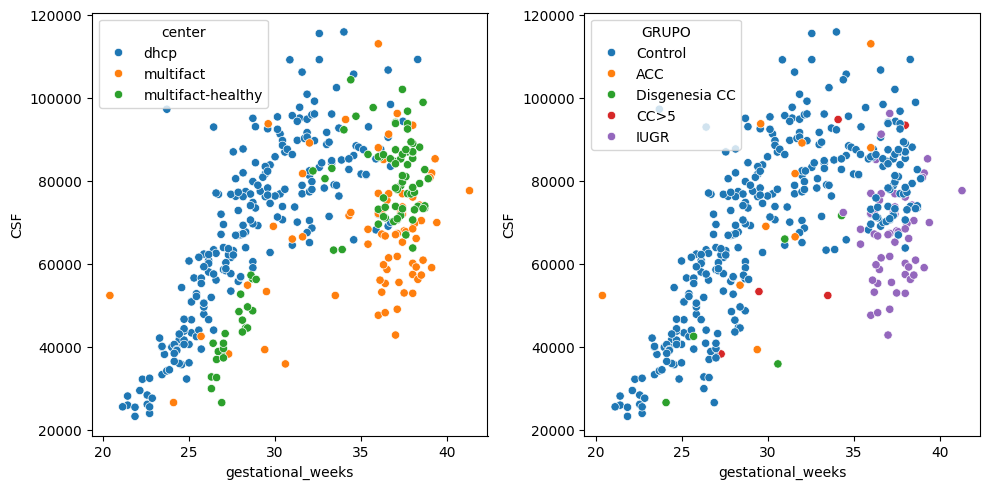

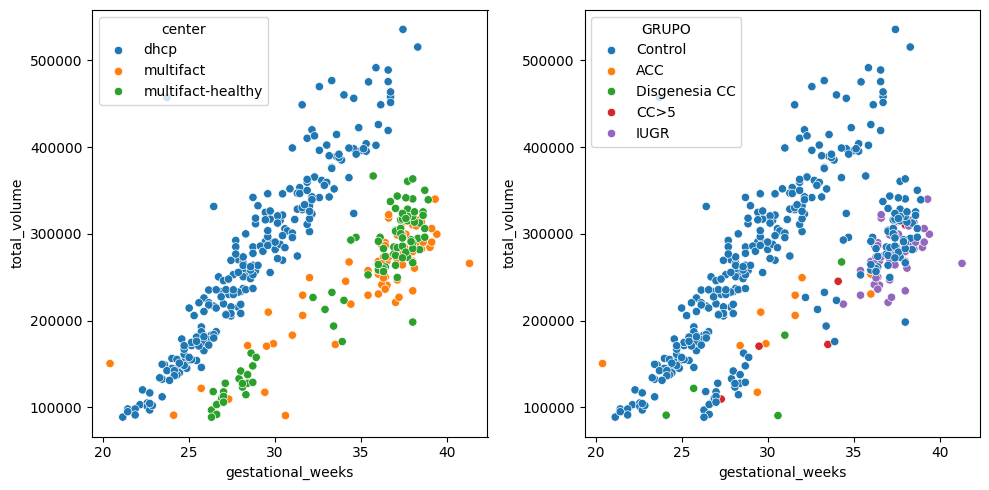

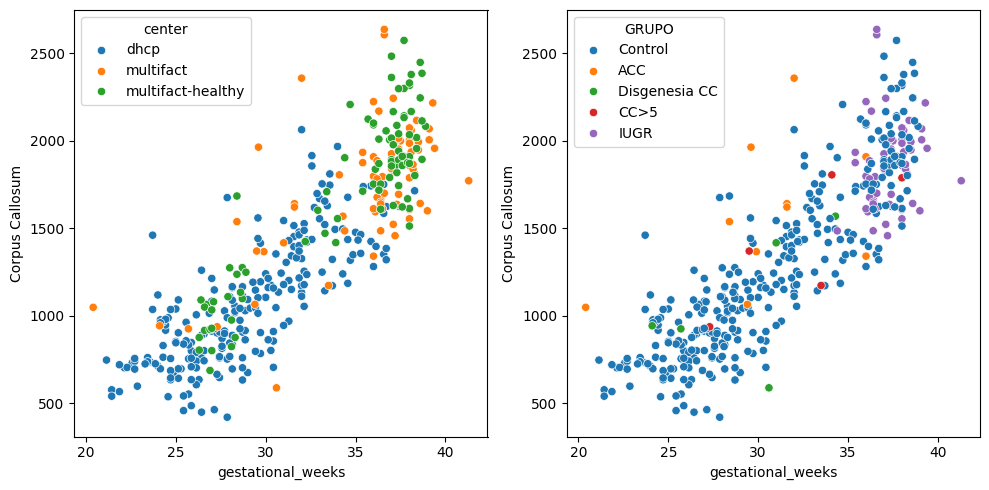

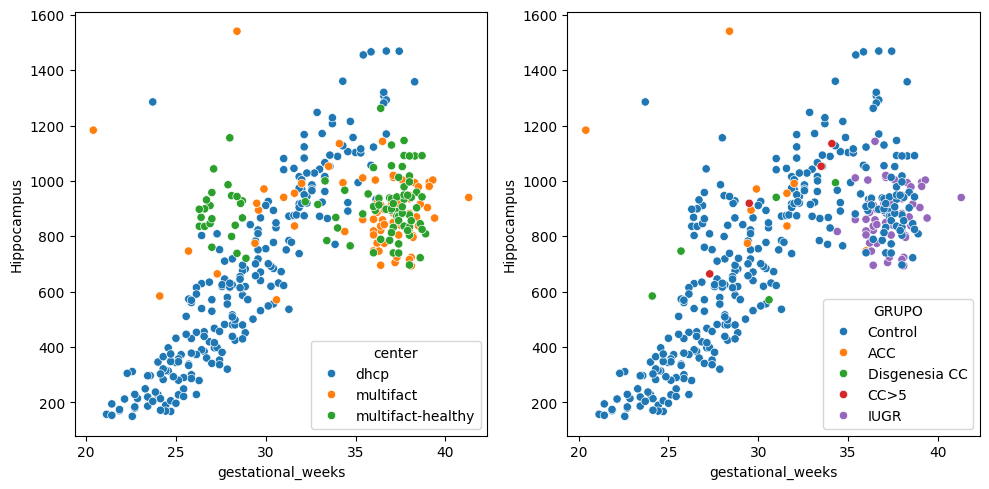

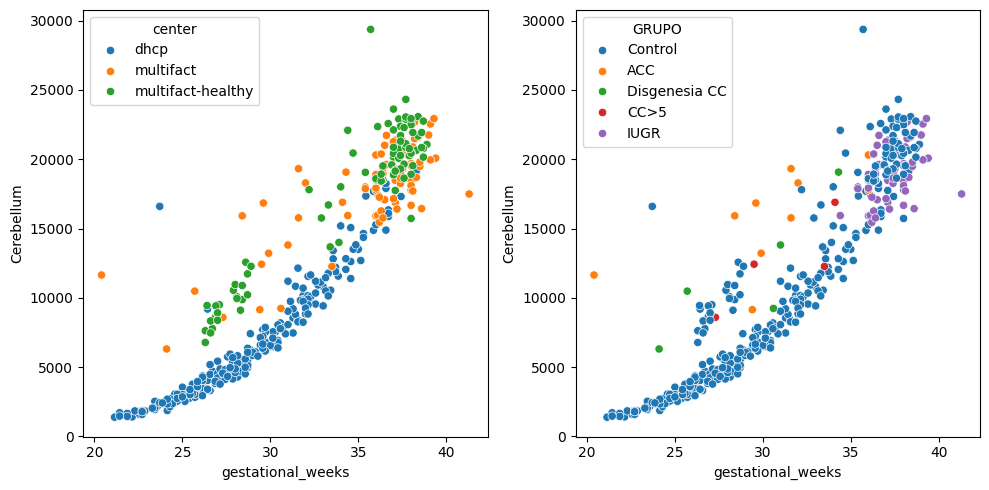

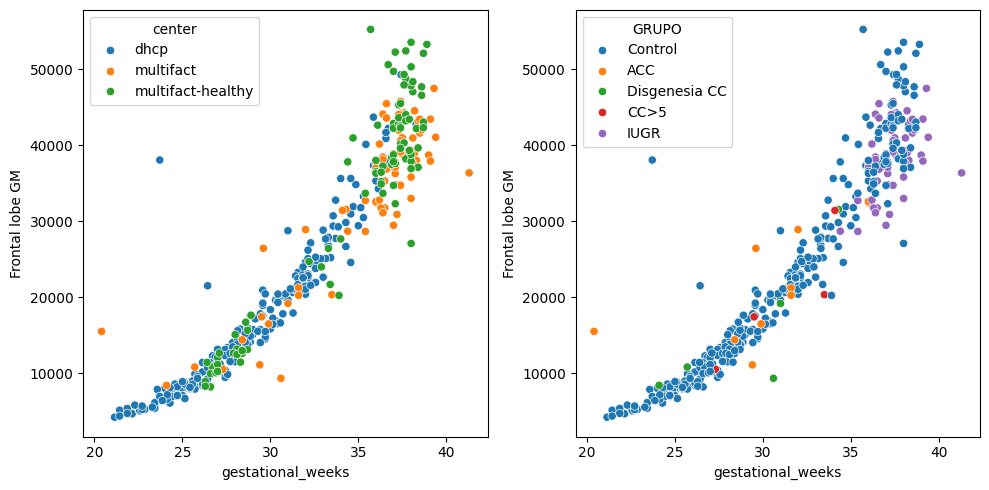

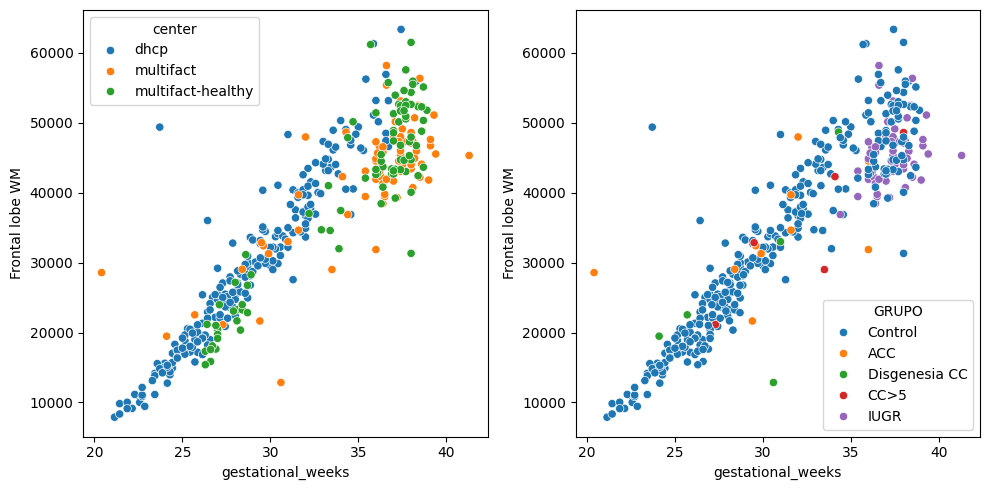

In [53]:
# The key variables are:

df_merged["Hippocampus"] = df_merged["Hippocampus left"] + df_merged["Hippocampus right"]
df_merged["Amygdala"] = df_merged["Amygdala left"] + df_merged["Amygdala right"]
df_merged["Cerebellum"] = df_merged["Cerebellum left"] + df_merged["Cerebellum right"]
df_merged["Frontal lobe GM"] = df_merged["Frontal lobe left GM"] + df_merged["Frontal lobe right GM"]
df_merged["Frontal lobe WM"] = df_merged["Frontal lobe left WM"] + df_merged["Frontal lobe right WM"]

variables_to_plot = ["CSF", "total_volume", "Corpus Callosum", "Hippocampus", "Cerebellum", "Frontal lobe GM", "Frontal lobe WM"]

# For each variable, plot two scatter plots:
# 1. One scatter plot with the values from the merged dataset, with the color of the points indicating the center
# 2. One scatter plot with the values from the merged dataset, with the color of the points indicating the group

for variable in variables_to_plot:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    sns.scatterplot(data=df_merged, x="gestational_weeks", y=variable, hue="center", ax=axs[0])
    sns.scatterplot(data=df_merged, x="gestational_weeks", y=variable, hue="GRUPO", ax=axs[1])
    plt.tight_layout()
